In [6]:
import random
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from scripts import MONGO_URL, END_DATE, GITHUB_TOKENS
from scripts.analysis import data, plot

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

plot.init_matplotlib()

W, H = 6, 2.5

In [2]:
client = MongoClient(MONGO_URL)
db = client['fake_stars']
# collection = db['fake_actor_events']
collection = db['fake_actor_events']
documents = list(collection.find({}))

df = pd.DataFrame(documents)

"""
repos_with_campaign = data.get_repos_with_campaign()
low_activity_actors_in_campaign = data.get_unique_actors(
    "low_activity_stars",
    {"low_activity": True, "repo": {"$in": list(repos_with_campaign)}},
)
clustered_actors_in_campaign = data.get_unique_actors(
    "clustered_stars", {"clustered": True, "repo": {"$in": list(repos_with_campaign)}},)

df = df[df.actor.isin(low_activity_actors_in_campaign |
                      clustered_actors_in_campaign)]
"""


def compute_actor_features(df):
    # Group by actor and calculate total and activity-specific counts
    actor_group = df.groupby('actor').agg(
        total_activities=('type', 'count'),
        stars=('type', lambda x: (x == 'WatchEvent').sum()),
        issues=('type', lambda x: (x == 'IssuesEvent').sum()),
        prs=('type', lambda x: (x == 'PullRequestEvent').sum()),
        creates=('type', lambda x: (x == 'CreateEvent').sum()),
        forks=('type', lambda x: (x == 'ForkEvent').sum()),
        pushs=('type', lambda x: (x == 'PushEvent').sum()),
        comments=('type', lambda x: ((x.str.contains('Comment'))
                  | x.str.contains('Review')).sum())
    ).reset_index()
    N = actor_group['total_activities']
    # Calculate the percentages of each activity type
    actor_group['star_ratio'] = actor_group['stars'] / N

    actor_group['issue_ratio'] = actor_group['issues'] / N

    actor_group['pr_ratio'] = actor_group['prs'] / N

    actor_group['create_ratio'] = actor_group['creates'] / N

    actor_group['fork_ratio'] = actor_group['forks'] / N

    actor_group['push_ratio'] = actor_group['pushs'] / N

    actor_group['comment_ratio'] = actor_group['comments'] / N
    actor_group['other_ratio'] = 1 - (actor_group['star_ratio'] + actor_group['issue_ratio']
                                      + actor_group['pr_ratio'] +
                                      actor_group['create_ratio']
                                      + actor_group['fork_ratio'] +
                                      actor_group['push_ratio']
                                      + actor_group['comment_ratio'])
    actor_group.fillna(0, inplace=True)

    return actor_group


# Compute the features
actor_features = compute_actor_features(df)

features = actor_features[['star_ratio', 'issue_ratio', 'pr_ratio', 'comment_ratio',
                           'create_ratio', 'fork_ratio', 'push_ratio', 'other_ratio']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [26]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import SpectralClustering
from multiprocessing import Pool
from sklearn.cluster import DBSCAN
k_values = range(2, 8)

# List to store the silhouette scores for each k
silhouette_scores = []
silhouette_scores_kmeans = []

# def get_silhouette_scores(k, features):
#     speatral_model = SpectralClustering(
#         n_clusters=k, random_state=42, assign_labels='kmeans',
#         affinity='nearest_neighbors').fit(features)
#     labels = speatral_model.labels_
#     return metrics.silhouette_score(features, labels, metric='euclidean')


# with Pool(len(k_values)) as pool:
#    silhouette_scores = pool.starmap(
#        get_silhouette_scores, [(k, scaled_features) for k in k_values])
for k in k_values:
    speatral_model = SpectralClustering(n_clusters=k, random_state=42, assign_labels='kmeans',
                                        affinity='nearest_neighbors').fit(scaled_features)
    labels = speatral_model.labels_
    score = metrics.silhouette_score(
        scaled_features, labels, metric='euclidean')
    
    kmeans_model = KMeans(n_clusters=k).fit(scaled_features)
    labels = kmeans_model.labels_
    score2 = metrics.silhouette_score(
        scaled_features, labels, metric='euclidean')

    print(k, score, score2)
    silhouette_scores.append(score)
    silhouette_scores_kmeans.append(score2)


2 0.5529204016203589 0.6836822133421199
3 0.6089575725690638 0.7052673180432703
4 0.6318414242863702 0.7556475637162138
5 0.6379514371344778 0.7621443143013553
6 0.6242272795116923 0.7700928020534648
7 0.6454858227095481 0.7774377615489871


In [38]:
# spectral clustering algorithm
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(
    n_clusters=4,
    random_state=42,
    assign_labels='kmeans',  # Options: 'kmeans' or 'discretize'
    affinity='nearest_neighbors'  # Options: 'rbf', 'nearest_neighbors', 'precomputed'
)

# Fit and predict cluster labels
actor_features['cluster'] = spectral_clustering.fit_predict(scaled_features)
ratio_columns = ['star_ratio', 'issue_ratio', 'pr_ratio', 'create_ratio',
                 'fork_ratio', 'push_ratio', 'comment_ratio','other_ratio', "total_activities"]

cluster_means = actor_features.groupby('cluster')[ratio_columns].mean()

# Print the cluster means
print(cluster_means)
cluster_counts = actor_features.groupby('cluster').size().reset_index(name='actor_count')
print(cluster_counts)


         star_ratio  issue_ratio  pr_ratio  create_ratio    fork_ratio  \
cluster                                                                  
0          0.999997     0.000001  0.000000  7.879739e-07  4.275964e-07   
1          0.928410     0.002642  0.001017  2.300079e-02  2.359469e-02   
2          0.383468     0.031166  0.028583  1.338099e-01  4.904189e-02   
3          0.491484     0.000132  0.000201  8.448040e-04  5.061753e-01   

           push_ratio  comment_ratio   other_ratio  total_activities  
cluster                                                               
0        7.997675e-08       0.000000  1.728781e-20          5.087045  
1        1.675915e-02       0.003850  7.264991e-04        360.740686  
2        2.983457e-01       0.051349  2.423641e-02        574.974538  
3        9.944898e-04       0.000135  3.298296e-05         12.672630  
   cluster  actor_count
0        0         6422
1        1          671
2        2         2435
3        3          559


In [41]:
# Kmeans clustering algorithm
from sklearn.cluster import kmeans_plusplus
actor_features['cluster']  = KMeans(n_clusters=4).fit_predict(scaled_features)

ratio_columns = ['star_ratio', 'issue_ratio', 'pr_ratio', 'create_ratio',
                 'fork_ratio', 'push_ratio', 'comment_ratio','other_ratio', "total_activities"]

cluster_means = actor_features.groupby('cluster')[ratio_columns].mean()

# Print the cluster means
print(cluster_means)
cluster_counts = actor_features.groupby('cluster').size().reset_index(name='actor_count')
print(cluster_counts)

         star_ratio  issue_ratio  pr_ratio  create_ratio  fork_ratio  \
cluster                                                                
0          0.971346     0.001602  0.000628      0.008462    0.005850   
1          0.499161     0.001276  0.000320      0.009261    0.476754   
2          0.240043     0.014678  0.038701      0.181680    0.029231   
3          0.288209     0.156307  0.037895      0.047420    0.033718   

         push_ratio  comment_ratio  other_ratio  total_activities  
cluster                                                            
0          0.009388       0.002162     0.000562         61.216017  
1          0.011380       0.001509     0.000338         21.615385  
2          0.432965       0.027427     0.035274        642.794908  
3          0.163995       0.254309     0.018148       1021.232143  
   cluster  actor_count
0        0         7717
1        1          676
2        2         1414
3        3          280


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

unique_clusters = [0,1,2,3]
perplexities = [30, 50, 100]
tsne_df = {}
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000, random_state=114514)
    tsne_results = tsne.fit_transform(scaled_features)

    tsne_df[p] = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df[p]['cluster'] = actor_features['cluster']

    


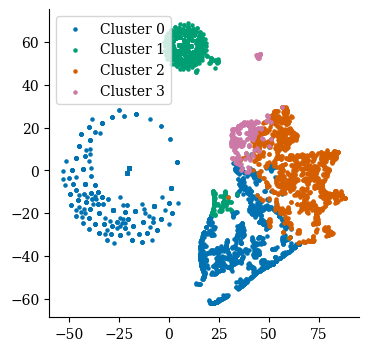

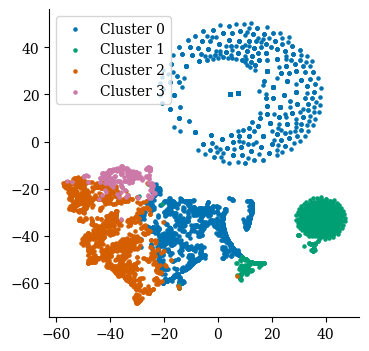

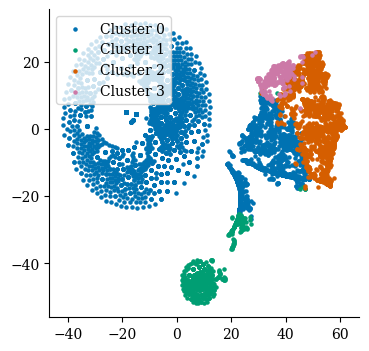

In [43]:

import matplotlib.pyplot as plt

color_dict = {0: "C0", 1: "C1", 2: "C2", 3:"C3", 4:"C4"}

for p in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.grid(False)
    for cluster in unique_clusters:
        cluster_data = tsne_df[p][tsne_df[p]['cluster'] == cluster]
        
        ax.scatter(
            cluster_data['TSNE1'],
            cluster_data['TSNE2'],
            c=[color_dict[cluster]],    # Color assigned to this cluster
            label=f'Cluster {cluster}', # Label for the legend
            s=5,                       # Marker size; adjust as needed
            marker='o'
        )

    ax.legend(loc='upper left')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.savefig(f"plots/tsne-users-{p}.pdf", bbox_inches="tight", dpi=300)

